In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Isoform half-life diversity

In [2]:
anno = pd.read_csv("../old.08_blastocyst.old/results.0406/mouse_transcript_annotation.tsv", sep="\t", header=0, index_col=1)
anno.head()

,TranscriptID,TranscriptType,GeneID,GeneName,GeneType,Chrom,Start,End,Strand
TranscriptName,,,,,,,,,
4933401J01Rik-201,ENSMUST00000193812.1,TEC,ENSMUSG00000102693.1,4933401J01Rik,TEC,chr1,3073252,3074322,+
Gm26206-201,ENSMUST00000082908.1,snRNA,ENSMUSG00000064842.1,Gm26206,snRNA,chr1,3102015,3102125,+
Xkr4-203,ENSMUST00000162897.1,processed_transcript,ENSMUSG00000051951.5,Xkr4,protein_coding,chr1,3205900,3216344,-
Xkr4-202,ENSMUST00000159265.1,processed_transcript,ENSMUSG00000051951.5,Xkr4,protein_coding,chr1,3206522,3215632,-
Xkr4-201,ENSMUST00000070533.4,protein_coding,ENSMUSG00000051951.5,Xkr4,protein_coding,chr1,3214481,3671498,-


ICM-1	2438	49	13
ICM-2	3555	161	62
EPI	2881	89	36
PE	2498	65	17
TE-1	2209	28	6
TE-2	2650	73	32
muralTE	1943	59	8
polarTE	1762	56	12


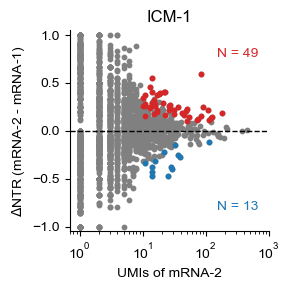

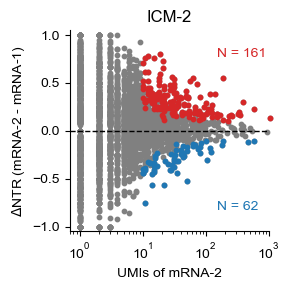

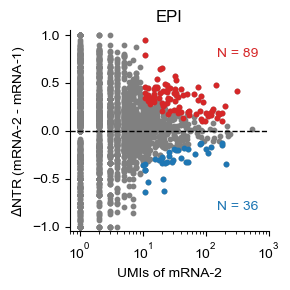

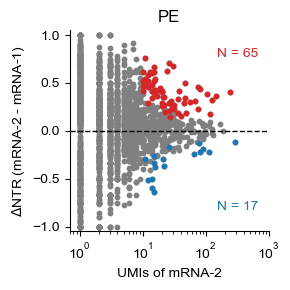

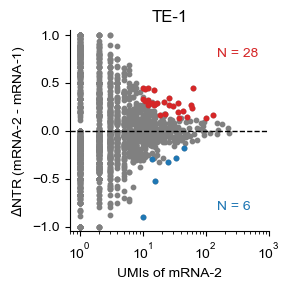

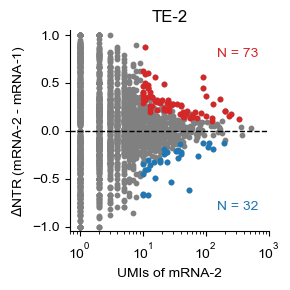

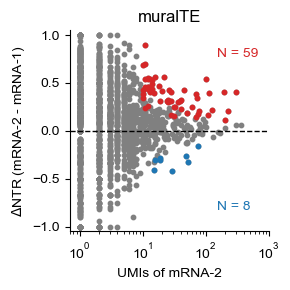

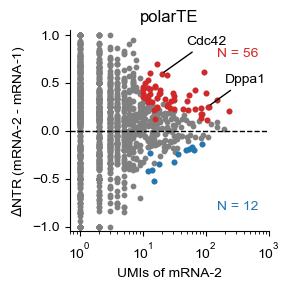

In [33]:
cts = ["ICM-1", "ICM-2", "EPI", "PE", "TE-1", "TE-2", "muralTE", "polarTE"]
array = []
for ct in cts:
    path = "../old.08_blastocyst.old/results.0406/halflife/%s_transcripts.transcript_name.tsv" % ct
    path2 = "../old.08_blastocyst.old/results.0406/isoform_halflife_diversity/%s_ntr_diff.tsv" % ct
    
    if not os.path.exists(path2):
        d = pd.read_csv(path, sep="\t", index_col=0)
        d = d.merge(anno, left_index=True, right_index=True)
        d = d[d["Total"] >= 1]
        d = d[d["TranscriptType"] == "protein_coding"]

        rows = []
        for gname, tmp in d.groupby(by="GeneName"):
            if len(tmp) > 1:
                tmp = tmp.sort_values(by="TPM", ascending=False)
                tmp = tmp.head(2)
                tid1, tid2 = tmp.index.values
                total1, total2 = tmp["Total"].values
                nascent1, nascent2 = tmp["Nascent"].values
                ntr1, ntr2 = tmp["NTR"].values
                tpm1, tpm2 = tmp["TPM"].values
                t1, t2 = tmp["T"].values
                ttype1, ttype2 = tmp["TranscriptType"].values
                pvalue = fisher_exact([[total1 - nascent1, nascent1], [total2 - nascent2, nascent2]])[1]
                row = [gname,
                    tid1, total1, nascent1, ntr1, t1, tpm1, ttype1, 
                    tid2, total2, nascent2, ntr2, t2, tpm2, ttype2, 
                    pvalue]
                rows.append(row)

        m = pd.DataFrame(rows)
        m.columns = ["GeneName", 
                     "TranscriptName1", "Total1", "Nascent1", "NTR1", "T1", "TPM1", "TranscriptType1", 
                     "TranscriptName2", "Total2", "Nascent2", "NTR2", "T2", "TPM2", "TranscriptType2", 
                     "Pvalue"]
        m["NTR.Diff"] = m["NTR2"] - m["NTR1"]
        m.to_csv(path2, sep="\t", index=False)
        
    m = pd.read_csv(path2, sep="\t", header=0)
    
    m1 = m[(m["Total2"] >= 10) & (m["NTR.Diff"] > 0.1) & (m["Pvalue"] < 0.05)]
    m2 = m[(m["Total2"] >= 10) & (m["NTR.Diff"] < -0.1) & (m["Pvalue"] < 0.05)]
    m3 = m1.copy()
    m3["CellType"] = ct
    array.append(m3)
    print(ct, len(m), len(m1), len(m2), sep="\t")
    xs, ys = m["Total2"], m["NTR.Diff"]
    xs1, ys1 = m1["Total2"], m1["NTR.Diff"]
    xs2, ys2 = m2["Total2"], m2["NTR.Diff"]
    plt.figure(figsize=(3, 3))
    plt.title(ct)
    plt.scatter(xs, ys, marker="o", s=10, color="grey", clip_on=False)
    plt.scatter(xs1, ys1, marker="o", s=10, color="C3", clip_on=False)
    plt.scatter(xs2, ys2, marker="o", s=10, color="C0", clip_on=False)
    plt.text(150, 0.8, "N = %d" % len(xs1), ha="left", va="center", color="C3")
    plt.text(150, -0.8, "N = %d" % len(xs2), ha="left", va="center", color="C0")
    plt.axhline(0, lw=1, ls="--", color="black")
    plt.xscale("log")
    plt.xlim(0.7, 1000)
    plt.ylim(-1.05, 1.05)

    if ct == "polarTE":
        x = m[m["GeneName"] == "Cdc42"]["Total2"]
        y = m[m["GeneName"] == "Cdc42"]["NTR.Diff"]
        plt.gca().annotate('Cdc42', xy=(x, y), xytext=(50, 0.9),
            arrowprops=dict(arrowstyle="-", facecolor='black'),)
    
        x = m[m["GeneName"] == "Dppa1"]["Total2"]
        y = m[m["GeneName"] == "Dppa1"]["NTR.Diff"]
        plt.gca().annotate('Dppa1', xy=(x, y), xytext=(200, 0.5),
            arrowprops=dict(arrowstyle="-", facecolor='black'),)
    
    plt.xlabel("UMIs of mRNA-2")
    plt.ylabel("$\Delta$NTR (mRNA-2 - mRNA-1)")
    for loc in ["top", "right"]:
        plt.gca().spines[loc].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/isoform_halflife_diversity.%s.pdf" % ct, dpi=300)
    # plt.close()
    # break

In [34]:
tmp = pd.concat(array, ignore_index=True)
tmp.to_csv("results/isoform_halflife_diversity.celltype.tsv", sep="\t", index=False)

In [35]:
df = pd.read_csv("../old.08_blastocyst.old/results/isoform_halflife_diversity.celltype.tsv", sep="\t")
df = df[df["CellType"].isin(["EPI", "PE", "muralTE", "polarTE"])]
", ".join(set(df["GeneName"]))

'Znhit1, Fmr1nb, Anapc11, Rps19, Rps9, Eloc, Rps7, Anxa6, Cebpzos, Dynlrb1, Sri, Timm10b, Gna13, Ran, Mrpl15, Banf1, Prdx2, Rps5, Atp5j, Trappc1, Txn2, Nme4, 1500011B03Rik, Chmp2a, Lmna, Eif5a, Bax, Prdx6, Anapc16, Nme2, Spint2, Lamtor2, Pdzk1ip1, Rab11a, Ndufv3, Ubb, Nme6, Cystm1, Mrpl58, Ccdc28a, Rpl32, Fcf1, Slc1a3, Mrpl11, Acpp, Hsp90aa1, Cinp, Tmbim6, Ctsc, Park7, Cox16, Ift20, Ssu72, Ywhaq, Hspa5, Ppp1r14b, Ung, Rnf10, Dppa1, Ndufs8, Arpc2, Set, Ndufs4, Ak2, Erh, Rps24, Ssbp1, Dynll1, Pdgfa, Pkm, Tm9sf3, Rcn3, Tecr, Btf3, Commd10, Pafah1b3, Lsr, Rbpms, Ckmt1, Serpinh1, Bcat1, Tsta3, Dpy30, Atp5c1, Mkrn1, Crxos, Cks1b, Npm1, Ola1, Snx12, Fis1, Snrpa, Rpl30, Sars, Dab2, Rpp21, Aldoa, Calm2, Aurkaip1, Rpl29, Rps15, Gnpda1, Ube2f, Canx, Lgals3, Cdc34, Apoe, Slc35b2, Mtch2, Rbx1, Khdc3, Nfs1, Cenpm, Pkig, Tcl1, Pfdn4, Bud31, Ppih, Atrx, Mcm6, Pgls, Selenoh, AA467197, Ntpcr, Psap, Mdk, Mtor, U2af1, Swi5, Vps51, H13, Rps2, Ost4, Uba52, Msrb1, Sh3glb1, Rpl8, Ybx3, Cdc42, Ptma, Ppp2r5c, R

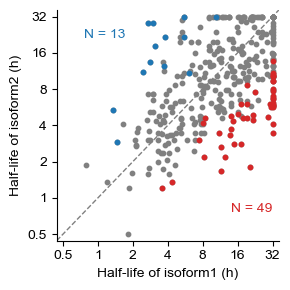

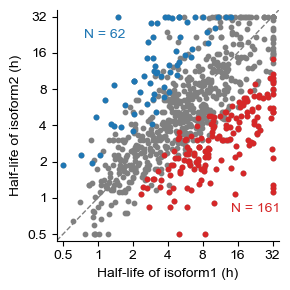

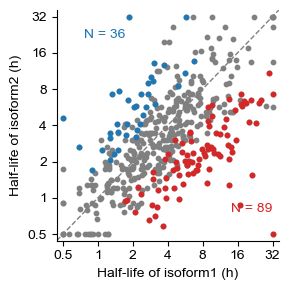

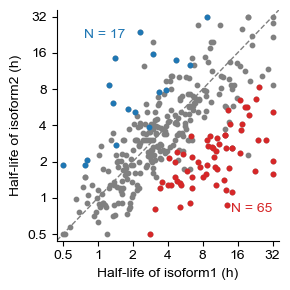

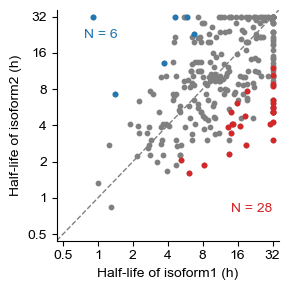

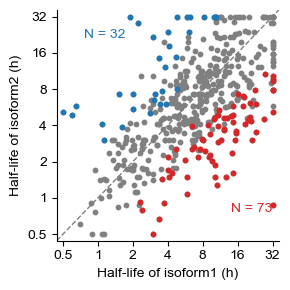

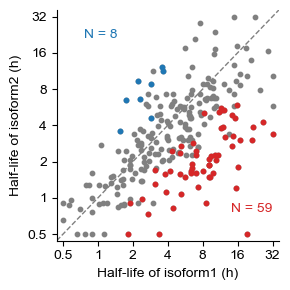

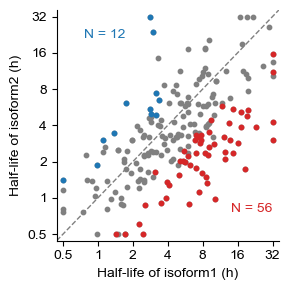

In [36]:
def correct_halflife(time, ntrs, tmin, tmax):
    hts = []
    for ntr in ntrs:
        if ntr == 0:
            hts.append(tmax)
        elif ntr == 1:
            hts.append(tmin)
        else:
            ht = -time/np.log2(1-ntr)
            ht = max(min(ht, tmax), tmin)
            hts.append(ht)
    return hts
    
for ct in cts:
    path = "../old.08_blastocyst.old/results.0406/isoform_halflife_diversity/%s_ntr_diff.tsv" % ct
    m = pd.read_csv(path, sep="\t")
    m["Total.Min"] = m[["Total1", "Total2"]].min(axis=1)
    
    x1, x2 = -1, 5
    w = x2 - x1
    m = m[m["Total.Min"] >= 10]
    m["T1"] = correct_halflife(3, m["NTR1"], 2**x1, 2**x2)
    m["T2"] = correct_halflife(3, m["NTR2"], 2**x1, 2**x2)
    m1 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] > 0.1) & (m["Pvalue"] < 0.05)]
    m2 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] < -0.1) & (m["Pvalue"] < 0.05)]
    xs, ys = np.log2(m["T1"]), np.log2(m["T2"])
    xs1, ys1 = np.log2(m1["T1"]), np.log2(m1["T2"])
    xs2, ys2 = np.log2(m2["T1"]), np.log2(m2["T2"])
    s = 10
    plt.figure(figsize=(3, 3))
    plt.scatter(xs, ys, s=s, color="grey", clip_on=False)
    plt.scatter(xs1, ys1, s=s, color="C3", clip_on=False)
    plt.scatter(xs2, ys2, s=s,color="C0", clip_on=False)
    plt.text(x1 + w * 0.8, x1 + w * 0.1, "N = %d" % len(m1), color="C3")
    plt.text(x1 + w * 0.1, x1 + w * 0.9, "N = %d" % len(m2), color="C0")
    plt.plot([x1 - w * 0.03, x2 + w * 0.03], [x1 - w * 0.03, x2 + w * 0.03], lw=1, ls="--", color="grey")
    plt.xlim(x1 - w * 0.03, x2 + w * 0.03)
    plt.ylim(x1 - w * 0.03, x2 + w * 0.03)
    plt.xlabel("Half-life of isoform1 (h)")
    plt.ylabel("Half-life of isoform2 (h)")
    vs = np.arange(x1, x2 + 1)
    plt.xticks(vs, [2**int(v) for v in vs])
    plt.yticks(vs, [2**int(v) for v in vs])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    # plt.savefig("figures/isoform_halflife_diff.mRNA.%s.pdf" % cl)

In [62]:
m[m["GeneName"] == "Dppa1"]

,GeneName,TranscriptName1,Total1,Nascent1,NTR1,T1,TPM1,TranscriptType1,TranscriptName2,Total2,Nascent2,NTR2,T2,TPM2,TranscriptType2,Pvalue,NTR.Diff,Total.Min
431,Dppa1,Dppa1-202,565,178,0.315044,5.495338,1672.691316,protein_coding,Dppa1-201,109,62,0.568807,2.471993,322.696201,protein_coding,0.000001,0.253763,109


# Prepare data for IGV track

In [3]:
from pyBioInfo.IO.File import BedFile, BamFile
from pyBioInfo.Utils import BlockTools

In [4]:
with BedFile("/home/chenzonggui/species/mus_musculus/GRCm38.p6/gencode.vM25.annotation.transcripts.bed.gz") as f:
    transcripts = {t.name: t for t in f}

In [5]:
anno = pd.read_csv("../old.08_blastocyst.old/results.0406/mouse_transcript_annotation.tsv", sep="\t", header=0)
for tid, tname in anno[["TranscriptID", "TranscriptName"]].values:
    if tid in transcripts:
        t = transcripts[tid]
        t.name = tname
        transcripts[t.name] = t

In [58]:
def keep_alignment(isoforms, alignment):
    introns2 = tuple([(x, y) for x, y in BlockTools.gaps(alignment.blocks)])
    for isoform in isoforms:
        introns1 = tuple([(x, y) for x, y in BlockTools.gaps(isoform.blocks)])
        if introns1 == introns2:
            return True
    return False

In [61]:
gene_name = "Cdc42"
isoform_names = ["Cdc42-201", "Cdc42-202"]

gene_name = "Dppa1"
isoform_names = ["Dppa1-201", "Dppa1-202"]

cts = ['EPI', 'polarTE']
outdir = "results/%s" % gene_name
if not os.path.exists(outdir):
    os.mkdir(outdir)
isoforms = [transcripts[x] for x in isoform_names]
chrom = isoforms[0].chrom
start = min([t.start for t in isoforms])
end = max([t.end for t in isoforms])
strand = isoforms[0].strand

path = outdir + "/isoforms.bed"
if not os.path.exists(path):
    with open(path, "w+") as fw:
        for x in isoforms:
            fw.write(x.format("BED") + "\n")

for ct in cts:
    path1 = "../10_blastocyst/results/cell_type_specific_bams/EPI.bam"
    path2 = outdir + "/%s.bam" % ct
    if not os.path.exists(path2):
        with BamFile(path1, random=True) as f, BamFile(path2, "wb", f) as fw:
            for a in f.fetch(chrom, start, end):
                if a.strand == strand and a.segment.get_tag("CS") >= 2 and keep_alignment(isoforms, a):
                    fw.write(a)
        cmd = "samtools index %s" % path2
        assert os.system(cmd) == 0

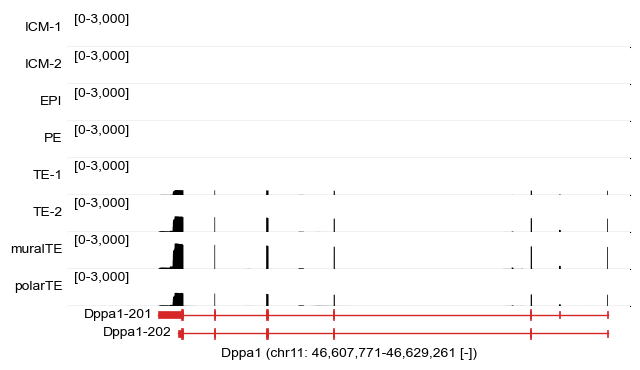

In [62]:
gene_name = "Cdc42"
isoform_names = ["Cdc42-201", "Cdc42-202"]

gene_name = "Dppa1"
isoform_names = ["Dppa1-201", "Dppa1-202"]

isoforms = [transcripts[x] for x in isoform_names]
chrom = isoforms[0].chrom
start = min([t.start for t in isoforms])
end = max([t.end for t in isoforms])
strand = isoforms[0].strand

# def get_coverage(bamfile, chrom, start, end, strand):
#     coverages = np.zeros(end - start)
#     with BamFile(bamfile, random=True) as f:
#         for align in f.fetch(chrom, start, end):
#             if align.strand != strand:
#                 continue
#             if align.segment.is_duplicate:
#                 continue
#             for x, y in align.blocks:
#                 x1, y1 = max(x, start), min(y, end)
#                 if x1 < y1:
#                     for idx in range(x1 - start, y1 - start):
#                         coverages[idx] += 1
#     return coverages

def get_coverages(celltype, chrom, start, end):
    import pyBigWig
    path = "../10_blastocyst/results/cell_type_specific_bams/%s.bw" % celltype
    bw = pyBigWig.open(path)
    covs = np.nan_to_num(bw.values(chrom, start, end), 0)
    bw.close()

    path = "../10_blastocyst/results/cell_type_specific_bams/%s.flagstat" % celltype
    for line in open(path):
        size = int(line.strip().split()[0])
        break
    covs = covs * 1000000 / size
    return covs    

def plot_coverages(ax, ct, start, end, coverages, xlims, ylims):
    ax0 = plt.gca()
    plt.sca(ax)
    plt.xlim(*xlims)
    plt.ylim(*ylims)
    plt.xticks([])
    plt.yticks([])
    plt.text(xlims[0] + (xlims[1] - xlims[0]) * 0.01, ylims[0] + (ylims[1] - ylims[0]) * 0.9, "[0-%s]" % format(ylims[1], ','), ha="left", va="top")
    plt.ylabel(ct, ha="right", va="center", rotation=0)
    ys = coverages
    xs = np.arange(start, end)
    plt.fill_between(xs, 0, ys, color="black", lw=0)
    plt.sca(ax0)

def plot_isoforms(ax, start, end, isoforms, xlims):
    ax0 = plt.gca()
    plt.sca(ax)
    plt.xlim(*xlims)
    plt.xticks([])
    for i, t in enumerate(isoforms):
        color = "C0" if t.strand == "+" else "C3"
        plt.text(t.start - (xlims[1] - xlims[0]) * 0.01, i + 0.5, t.name, ha="right", va="center")
        plt.plot([t.start, t.end], [i + 0.5, i + 0.5], color=color, lw=1)
        thick1 = 0.4 # exon
        thick2 = 0.6 # CDS
        for block in t.blocks:
            plt.fill_between([block[0], block[1]], 
                             [i + 0.5 - thick1 / 2, i + 0.5 - thick1 / 2], 
                             [i + 0.5 + thick1 / 2, i + 0.5 + thick1 / 2], lw=0.5, color=color, zorder=10)
        if t.thick:
            for block in t.blocks:
                x1, x2 = max(block[0], t.thick[0]), min(block[1], t.thick[1])
                if x1 >= x2:
                    continue
                plt.fill_between([x1, x2], 
                                 [i + 0.5 - thick2 / 2, i + 0.5 - thick2 / 2], 
                                 [i + 0.5 + thick2 / 2, i + 0.5 + thick2 / 2], lw=0.5, color=color, zorder=10)
    plt.ylim(len(isoforms), 0)
    plt.yticks([])
    plt.sca(ax0)

cts = ["ICM-1", "ICM-2", "EPI", "PE", "TE-1", "TE-2", "muralTE", "polarTE"]
coverages_list = []
for ct in cts:
    coverages = get_coverages(ct, chrom, start, end)
    coverages_list.append(coverages)

xlims = [start - (end - start) * 0.2, end + (end - start) * 0.05]
ymax = max([max(covs) for covs in coverages_list]) * 1.2
step = 10**max(int(np.log10(ymax)), 1)
ymax = (int(ymax / step) + 1) * step
ylims = [0, ymax]
fig, axs = plt.subplots(9, 1, figsize=(6.5, 3.8), gridspec_kw={"hspace": 0, "wspace": 0})
for i, ct in enumerate(cts):
    plot_coverages(axs[i], ct, start, end, coverages_list[i], xlims, ylims)
plot_isoforms(axs[-1], start, end, isoforms, xlims)
for ax in axs:
    for loc in ["left", "right", "top"]:
        ax.spines[loc].set_visible(False)
axs[-1].spines["bottom"].set_visible(False)
axs[-1].set_xlabel("%s (%s: %s-%s [%s])" % (gene_name, chrom, format(start, ","), format(end, ","), strand))
plt.tight_layout()
plt.savefig("figures/tracks_of_%s.pdf" % gene_name)